In [168]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from scipy import stats

In [127]:
df = pd.read_csv('diamonds.csv')


# color: diamond color from J (worst) to D (best)
# clarity: A measure of diamond clarity (from left to right is worst to best: I1, SI2, SI1, VS2, VS1, VVS2, VVS1, IF)

df.rename(columns = {'x':'length','y':'width','z':'depth','depth':'depth_percentage'}, inplace = True)
print(df)

df.isna().sum()

       carat        cut color clarity  depth_percentage  table  price  length  \
0       0.23      Ideal     E     SI2              61.5   55.0    326    3.95   
1       0.21    Premium     E     SI1              59.8   61.0    326    3.89   
2       0.23       Good     E     VS1              56.9   65.0    327    4.05   
3       0.29    Premium     I     VS2              62.4   58.0    334    4.20   
4       0.31       Good     J     SI2              63.3   58.0    335    4.34   
...      ...        ...   ...     ...               ...    ...    ...     ...   
49995   0.72      Ideal     D     SI1              60.8   57.0   2757    5.75   
49996   0.72       Good     D     SI1              63.1   55.0   2757    5.69   
49997   0.70  Very Good     D     SI1              62.8   60.0   2757    5.66   
49998   0.86    Premium     H     SI2              61.0   58.0   2757    6.15   
49999   0.75      Ideal     D     SI2              62.2   55.0   2757    5.83   

       width  depth  
0    

carat               0
cut                 0
color               0
clarity             0
depth_percentage    0
table               0
price               0
length              0
width               0
depth               0
dtype: int64

In [128]:
# Feature engineering: data recode (cut,color,clarity) 
recode_cut={'Fair':1,'Good':2,'Very Good':3,'Premium':4,'Ideal':5}
recode_color={'D':7,'E':6,'F':5,'G':4,'H':3,'I':2,'J':1}
recode_clarity={'I1':1,'SI2':2,'SI1':3,'VS2':4,'VS1':5,'VVS2':6,'VVS1':7,'IF':8}

df['cut'].replace(recode_cut,inplace=True)
df['color'].replace(recode_color,inplace=True)
df['clarity'].replace(recode_clarity,inplace=True)

print(df)

       carat  cut  color  clarity  depth_percentage  table  price  length  \
0       0.23    5      6        2              61.5   55.0    326    3.95   
1       0.21    4      6        3              59.8   61.0    326    3.89   
2       0.23    2      6        5              56.9   65.0    327    4.05   
3       0.29    4      2        4              62.4   58.0    334    4.20   
4       0.31    2      1        2              63.3   58.0    335    4.34   
...      ...  ...    ...      ...               ...    ...    ...     ...   
49995   0.72    5      7        3              60.8   57.0   2757    5.75   
49996   0.72    2      7        3              63.1   55.0   2757    5.69   
49997   0.70    3      7        3              62.8   60.0   2757    5.66   
49998   0.86    4      3        2              61.0   58.0   2757    6.15   
49999   0.75    5      7        2              62.2   55.0   2757    5.83   

       width  depth  
0       3.98   2.43  
1       3.84   2.31  
2       4

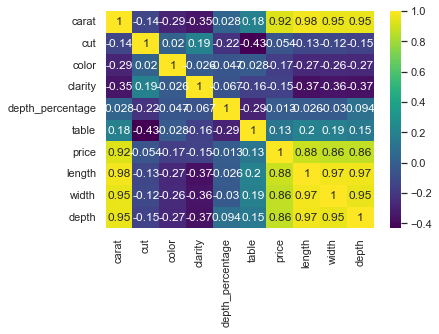

In [129]:
corrmat = df.corr()
g = sns.heatmap(corrmat,annot=True,cmap="viridis")

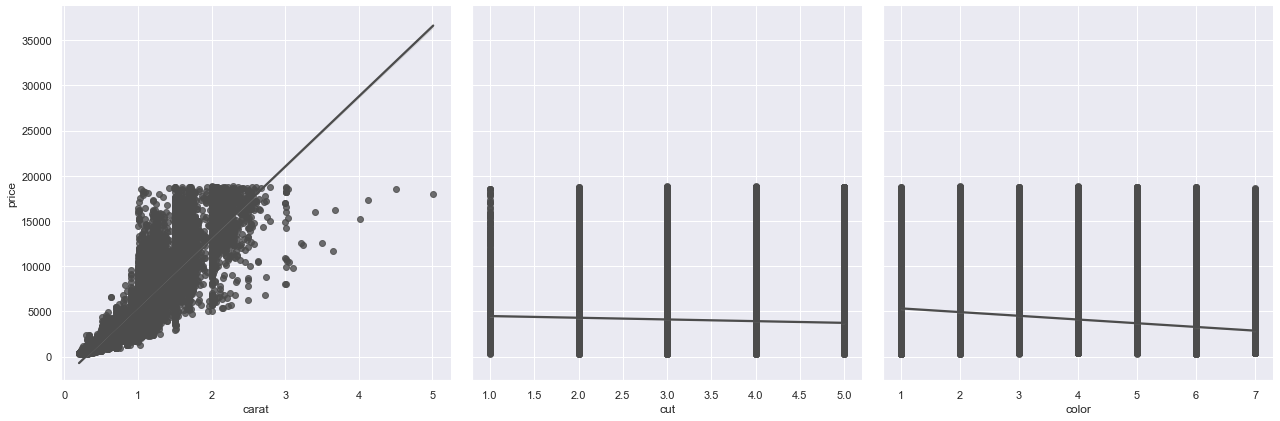

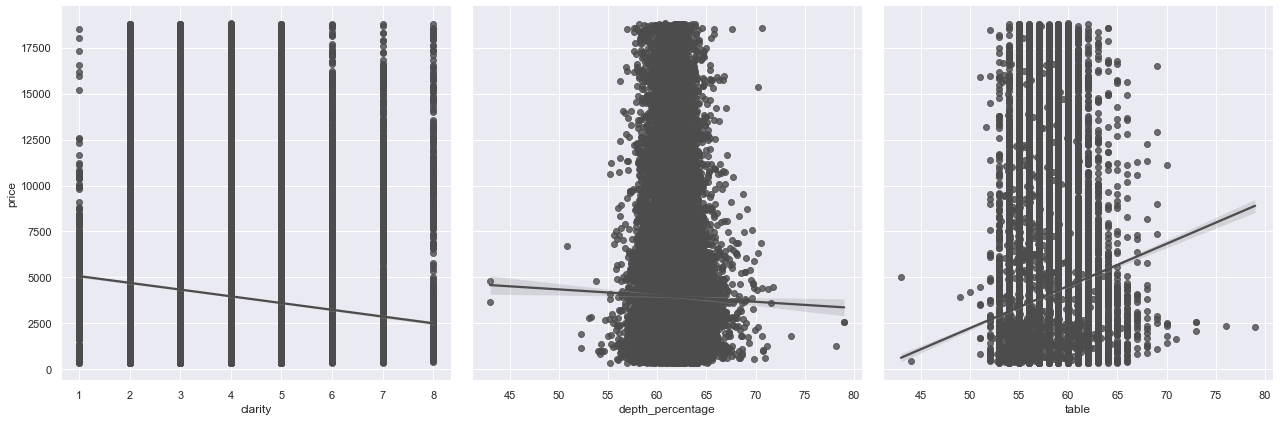

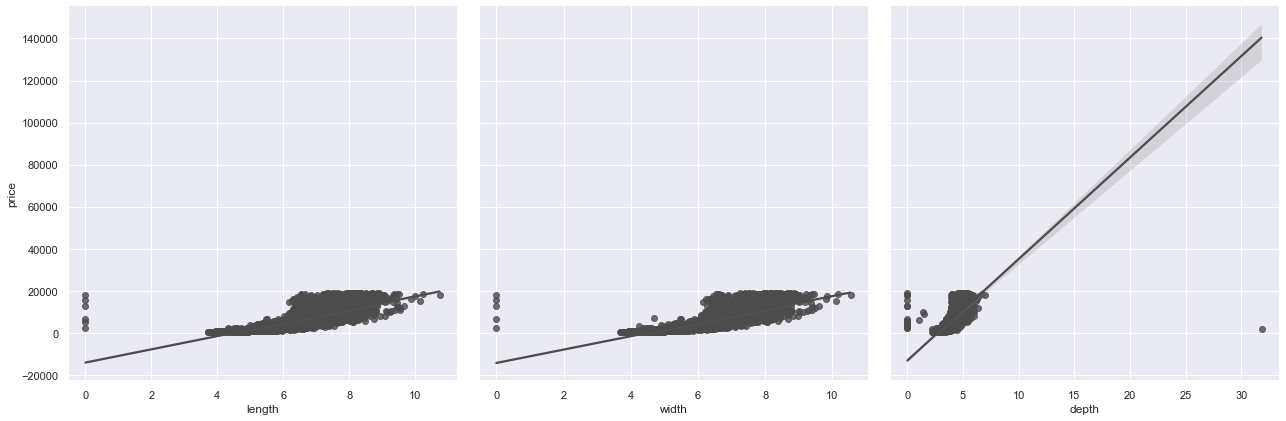

In [63]:
g=sns.PairGrid(df, y_vars=['price'],
             x_vars=['carat','cut','color'], height=6)
g.map(sns.regplot, color=".3")
g=sns.PairGrid(df, y_vars=['price'],
             x_vars=['clarity','depth_percentage','table'], height=6)
g.map(sns.regplot, color=".3")
g=sns.PairGrid(df, y_vars=['price'],
             x_vars=['length','width','depth'], height=6)
g.map(sns.regplot, color=".3")

# The heatmap and scatter plot with regression line show that thereis a higher positive correlation
# between price and (carat, length, width, depth), which are all size related variables.

In [130]:
# Combine length, width and depth
df['size']=df['length']*df['width']*df['depth']
df.drop(columns=['length','width','depth'], axis=1, inplace=True)

# Normalize
scaler = MinMaxScaler(feature_range = (0,1))
scaled_df = pd.DataFrame(data=scaler.fit_transform(df),index=df.index,columns=df.columns)

In [148]:
# Linear Regression - find best parameters
lr_model=LinearRegression()

test_size=[0.1,0.15,0.2,0.25,0.3]
random=[1,17,23,44,567]

best_ts=None
best_r=None
max_r2=-float('inf')

for ts in test_size:
    for r in random:
        # Split train and test datasets
        train_x,test_x,train_y,test_y = train_test_split(scaled_df.drop('price', axis=1),
                                                        scaled_df['price'], test_size=ts, random_state=r)
        lr_model.fit(train_x,train_y)
        lr_pred=lr_model.predict(test_x)
        
        r2 = metrics.r2_score(test_y,lr_pred)
        
        if r2>max_r2:
            max_r2=r2
            best_ts=ts
            best_r=r
        
print('Best test size: ',best_ts)
print('Best random state: ',best_r)
print("Maximum R2 Score:",max_r2)

Best test size:  0.1
Best random state:  23
Maximum R2 Score: 0.9101797235976491


In [149]:
# Linear Regression - Create model
train_x,test_x,train_y,test_y = train_test_split(scaled_df.drop('price', axis=1),
                                                scaled_df['price'], test_size=0.1, random_state=23)

lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(train_x, train_y)

pipeline = make_pipeline(StandardScaler(), LinearRegression())
scores = cross_val_score(pipeline, X=train_x, y=train_y, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

# Linear Regression - Predict
lr_pred = lr_model.predict(test_x)
r2=metrics.r2_score(test_y,lr_pred)

print('R2 Score:', r2)

Cross Validation accuracy scores: [0.9060742  0.90126754 0.90755369 0.90548929 0.89876548 0.91002121
 0.90419173 0.89767486 0.89114172 0.90702396]
Cross-Validation accuracy: 0.903 +/- 0.005
R2 Score: 0.9101797235976491


In [150]:
# Regression Tree - find best parameters
random=[1,17,23,44,567]

rt_model=DecisionTreeRegressor(random_state=12)

best_ts=None
best_r=None
max_r2=-float('inf')

for r in random:
    # Split train and test datasets
    train_x,test_x,train_y,test_y = train_test_split(scaled_df.drop('price', axis=1),
                                                    scaled_df['price'], test_size=ts, random_state=r)

    rt_model.fit(train_x,train_y)
    rt_pred=rt_model.predict(test_x)

    r2 = metrics.r2_score(test_y,rt_pred)

    if r2>max_r2:
        max_r2=r2
        best_ts=ts
        best_r=r
        
print('Best test size: ',best_ts)
print('Best random state: ',best_r)
print("Maximum R2 Score:",max_r2)

Best test size:  0.3
Best random state:  17
Maximum R2 Score: 0.9668917492678148


In [151]:
# Regression Tree - Create model
train_x,test_x,train_y,test_y = train_test_split(scaled_df.drop('price', axis=1),
                                                scaled_df['price'], test_size=0.3, random_state=17)

rt_model=DecisionTreeRegressor(random_state=12)
rt_model.fit(train_x, train_y)

pipeline = make_pipeline(StandardScaler(), rt_model)
scores = cross_val_score(pipeline, X=train_x, y=train_y, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

# Regression Tree - Predict
rt_pred=rt_model.predict(test_x)
r2=metrics.r2_score(test_y,rt_pred)

print('R2 Score:', r2)

Cross Validation accuracy scores: [0.96684618 0.9647873  0.96626804 0.96176405 0.96772275 0.96492299
 0.96132009 0.96806621 0.96550594 0.96051252]
Cross-Validation accuracy: 0.965 +/- 0.003
R2 Score: 0.9668917492678148


In [152]:
# Random Forest - find best parameters
random=[1,17,23,44,567]

rf_model=RandomForestRegressor(n_estimators = 1000,random_state=12)

best_ts=None
best_r=None
max_r2=-float('inf')

for r in random:
    # Split train and test datasets
    train_x,test_x,train_y,test_y = train_test_split(scaled_df.drop('price', axis=1),
                                                    scaled_df['price'], test_size=ts, random_state=r)

    rf_model.fit(train_x,train_y)
    rf_pred=rf_model.predict(test_x)

    r2 = metrics.r2_score(test_y,rf_pred)

    if r2>max_r2:
        max_r2=r2
        best_ts=ts
        best_r=r
        
print('Best test size: ',best_ts)
print('Best random state: ',best_r)
print("Maximum R2 Score:",max_r2)

Best test size:  0.3
Best random state:  567
Maximum R2 Score: 0.9822344120443439


In [189]:
# Random Forest - Create model
train_x,test_x,train_y,test_y = train_test_split(scaled_df.drop('price', axis=1),
                                                scaled_df['price'], test_size=0.3, random_state=567)

rf_model=RandomForestRegressor(n_estimators = 1000,random_state=12)
rf_model.fit(train_x, train_y)

pipeline = make_pipeline(StandardScaler(), rf_model)
scores = cross_val_score(pipeline, X=train_x, y=train_y, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

# Random Forest - Predict
rf_pred=rf_model.predict(test_x)
r2=metrics.r2_score(test_y,rf_pred)
mse = metrics.mean_squared_error(test_y, rf_pred)
rmse = np.sqrt(mse) 

print('R2 Score:', r2)
print("MSE: ", mse)
print("RMSE: ",rmse)

Cross Validation accuracy scores: [0.97530779 0.98229787 0.98013412 0.9804263  0.9802404  0.98073196
 0.97786308 0.98379525 0.98011599 0.98133095]
Cross-Validation accuracy: 0.980 +/- 0.002
R2 Score: 0.9822344120443439
MSE:  0.0008132175851633153
RMSE:  0.028516970125932302


In [175]:
final_pred = rf_model.predict(scaled_df.drop('price', axis=1))
actual_price=scaled_df['price']

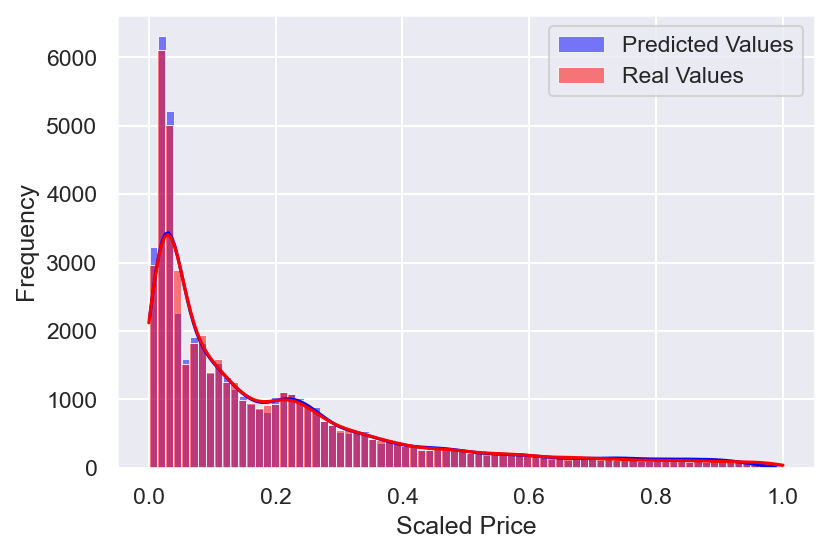

In [176]:
# train_x,test_x,train_y,test_y = train_test_split(scaled_df.drop('price', axis=1),
#                                                 scaled_df['price'], test_size=0.3, random_state=567)

plt.figure(dpi=150)
# sns.despine(trim=True, left=True)
sns.histplot(final_pred ,kde=True, label='Predicted Values',color='blue')
sns.histplot(actual_price ,kde=True, label='Real Values',color='red')
plt.xlabel('Scaled Price')
plt.ylabel('Frequency')
plt.legend()
plt.show();

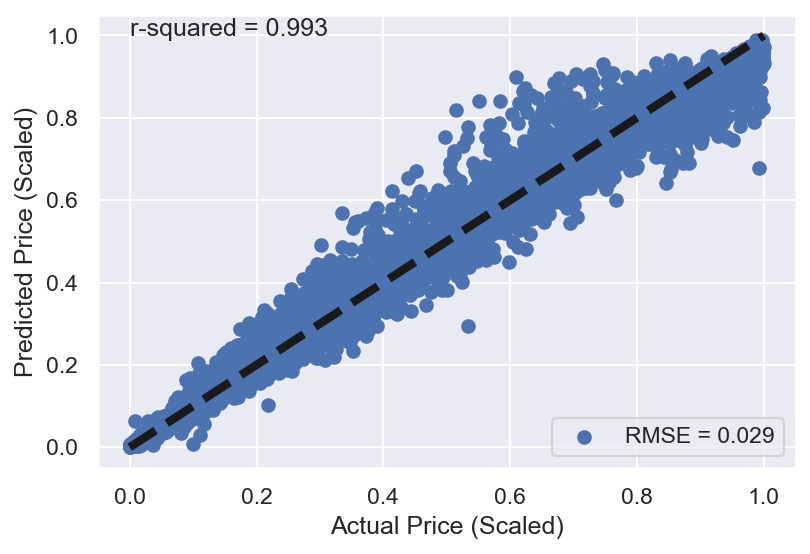

In [204]:

plt.figure(dpi=150)
plt.scatter(x=actual_price, y=final_pred)

labels_ = []
labels_.append("RMSE = {0:.2g}".format(rmse))

plt.legend(labels_, loc='lower right')

plt.plot([actual_price.min(), actual_price.max()], [actual_price.min(), actual_price.max()], 'k--', lw=4)
plt.xlabel('Actual Price (Scaled)')
plt.ylabel('Predicted Price (Scaled)')
plt.annotate("r-squared = {:.3f}".format(metrics.r2_score(actual_price, final_pred)), (0, 1))
plt.show()
